# Discriminator Model Trained on Weakly Supervised Data

In [1]:
from pathlib import Path

import pandas as pd
import plotnine as p9
import plydata as ply
import scipy.stats

# Load the Data

## Generative Model

In [3]:
gen_model_performance_dfs = pd.concat(
    [
        pd.read_csv(str(df_path), sep="\t")
        >> ply.query("data_source=='abstract'")
        >> ply.define(lf_num=ply.expressions.if_else("lf_num > 16", 99, "lf_num"))
        >> ply.define(
            lf_num=ply.expressions.case_when(
                {
                    "lf_num==1": "lf_num",
                    "lf_num==6": "lf_num",
                    "lf_num==11": "lf_num",
                    "lf_num==16": "lf_num",
                    "lf_num==99": "lf_num",
                    True: 0,
                }
            )
        )
        >> ply.define(
            label_source=ply.expressions.if_else(
                'label_source.str.contains("baseline")',
                'label_source.str.replace("_baseline", "")',
                "label_source",
            )
        )
        >> ply.define(prediction_label='"' + df_path.stem.split("_")[0] + '"')
        >> ply.select("-sampled_lf_name", "-bce_loss", "-data_source")
        >> ply.rename(dataset="model")
        >> ply.define(model='"Gen"')
        for df_path in (
            Path("../generative_model_training/output/performance").rglob(
                "*performance.tsv"
            )
        )
    ]
)
gen_model_performance_dfs

,lf_num,auroc,aupr,label_source,dataset,epochs,l2_param,lr_param,prediction_label,model
0,0,0.673485,0.189110,GiG,tune,250,1.2575,0.001,GiG,Gen
1,0,0.663729,0.305850,GiG,test,250,1.2575,0.001,GiG,Gen
2,1,0.673485,0.189110,DaG,tune,250,1.2575,0.001,GiG,Gen
3,1,0.664303,0.305925,DaG,test,250,1.2575,0.001,GiG,Gen
4,1,0.673902,0.237828,DaG,tune,250,1.2575,0.001,GiG,Gen
...,...,...,...,...,...,...,...,...,...,...
1999,99,0.598502,0.290482,GiG,test,250,0.0100,0.001,CtD,Gen
2000,99,0.682137,0.384323,GiG,tune,250,0.0100,0.001,CtD,Gen
2001,99,0.598502,0.290482,GiG,test,250,0.0100,0.001,CtD,Gen
2002,99,0.682137,0.384323,GiG,tune,250,0.0100,0.001,CtD,Gen


## Discriminative Model

In [4]:
disc_model_performance_dfs = pd.concat(
    [
        pd.read_csv(str(df_path), sep="\t")
        >> ply.call(".dropna")
        >> ply.define(model='"Disc"')
        >> ply.define(lf_num=ply.expressions.if_else("lf_num > 16", 99, "lf_num"))
        >> ply.define(
            lf_num=ply.expressions.case_when(
                {
                    "lf_num==1": "lf_num",
                    "lf_num==6": "lf_num",
                    "lf_num==11": "lf_num",
                    "lf_num==16": "lf_num",
                    "lf_num==99": "lf_num",
                    True: 0,
                }
            )
        )
        >> ply.define(
            label_source=ply.expressions.if_else(
                'label_source.str.contains("baseline")',
                'label_source.str.replace("_baseline", "")',
                "label_source",
            )
        )
        >> ply.query("prediction_edge == label_source")
        >> ply.rename(aupr="AUPR", auroc="AUROC", prediction_label="prediction_edge")
        for df_path in Path().rglob("output/*total_lf_performance.tsv")
    ]
)
disc_model_performance_dfs

,prediction_label,label_source,aupr,auroc,dataset,lf_num,model
1,GiG,GiG,0.196429,0.805556,tune,1,Disc
2,GiG,GiG,0.252755,0.788462,tune,1,Disc
3,GiG,GiG,0.207849,0.791667,tune,1,Disc
4,GiG,GiG,0.164696,0.706667,tune,1,Disc
5,GiG,GiG,0.215290,0.768519,tune,1,Disc
...,...,...,...,...,...,...,...
1595,CbG,CbG,0.141164,0.610162,test,0,Disc
1596,CbG,CbG,0.140026,0.610452,test,0,Disc
1597,CbG,CbG,0.142670,0.615063,test,0,Disc
1598,CbG,CbG,0.141666,0.615676,test,0,Disc


In [5]:
combined_models_df = gen_model_performance_dfs.append(disc_model_performance_dfs)
combined_models_df

,lf_num,auroc,aupr,label_source,dataset,epochs,l2_param,lr_param,prediction_label,model
0,0,0.673485,0.189110,GiG,tune,250.0,1.2575,0.001,GiG,Gen
1,0,0.663729,0.305850,GiG,test,250.0,1.2575,0.001,GiG,Gen
2,1,0.673485,0.189110,DaG,tune,250.0,1.2575,0.001,GiG,Gen
3,1,0.664303,0.305925,DaG,test,250.0,1.2575,0.001,GiG,Gen
4,1,0.673902,0.237828,DaG,tune,250.0,1.2575,0.001,GiG,Gen
...,...,...,...,...,...,...,...,...,...,...
1595,0,0.610162,0.141164,CbG,test,NaN,NaN,NaN,CbG,Disc
1596,0,0.610452,0.140026,CbG,test,NaN,NaN,NaN,CbG,Disc
1597,0,0.615063,0.142670,CbG,test,NaN,NaN,NaN,CbG,Disc
1598,0,0.615676,0.141666,CbG,test,NaN,NaN,NaN,CbG,Disc


# Clean up the data and add Confidence Intervals

In [6]:
def upper_ci(x):
    x.mean() + (scipy.stats.sem(x) * scipy.stats.t.ppf((1 + 0.95) / 2.0, len(x) - 1))


def lower_ci(x):
    x.mean() - (scipy.stats.sem(x) * scipy.stats.t.ppf((1 + 0.95) / 2.0, len(x) - 1))

In [7]:
performance_ci_df = (
    combined_models_df
    >> ply.query("label_source == prediction_label")
    >> ply.group_by("lf_num", "label_source", "prediction_label", "dataset", "model")
    >> ply.define(
        aupr_mean="mean(aupr)",
        aupr_upper_ci="upper_ci(aupr)",
        aupr_lower_ci="lower_ci(aupr)",
    )
    >> ply.define(
        auroc_mean="mean(auroc)",
        auroc_upper_ci="upper_ci(auroc)",
        auroc_lower_ci="lower_ci(auroc)",
    )
    >> ply.ungroup()
    >> ply.define(lf_num=ply.expressions.if_else("lf_num==99", '"All"', "lf_num"))
    >> ply.distinct()
    >> ply.arrange("lf_num")
)

performance_ci_df.lf_num = pd.Categorical(
    performance_ci_df.lf_num.tolist(),
    categories=["0", "1", "6", "11", "16", "All"],
    ordered=True,
)

performance_ci_df

/home/danich1/anaconda3/envs/snorkeling_full_text/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
/home/danich1/anaconda3/envs/snorkeling_full_text/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars


,lf_num,auroc,aupr,label_source,dataset,epochs,l2_param,lr_param,prediction_label,model,aupr_mean,aupr_upper_ci,aupr_lower_ci,auroc_mean,auroc_upper_ci,auroc_lower_ci
0,0,0.673485,0.189110,GiG,tune,250.0,1.2575,0.001,GiG,Gen,0.189110,NaN,NaN,0.673485,NaN,NaN
3025,0,0.458992,0.337271,DaG,tune,NaN,NaN,NaN,DaG,Disc,0.333316,0.343604,0.323028,0.463395,0.470051,0.456740
3026,0,0.460448,0.338626,DaG,tune,NaN,NaN,NaN,DaG,Disc,0.333316,0.343604,0.323028,0.463395,0.470051,0.456740
3027,0,0.467785,0.346633,DaG,tune,NaN,NaN,NaN,DaG,Disc,0.333316,0.343604,0.323028,0.463395,0.470051,0.456740
3028,0,0.468826,0.344484,DaG,tune,NaN,NaN,NaN,DaG,Disc,0.333316,0.343604,0.323028,0.463395,0.470051,0.456740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1214,All,0.757353,0.380921,GiG,tune,NaN,NaN,NaN,GiG,Disc,0.362015,0.386900,0.337129,0.768078,0.779224,0.756931
1213,All,0.737129,0.359600,GiG,tune,NaN,NaN,NaN,GiG,Disc,0.362015,0.386900,0.337129,0.768078,0.779224,0.756931
1212,All,0.747175,0.397602,GiG,tune,NaN,NaN,NaN,GiG,Disc,0.362015,0.386900,0.337129,0.768078,0.779224,0.756931
1224,All,0.745059,0.270966,GiG,tune,NaN,NaN,NaN,GiG,Disc,0.362015,0.386900,0.337129,0.768078,0.779224,0.756931


# Plot Performance

## Train

/home/danich1/anaconda3/envs/snorkeling_full_text/lib/python3.7/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_errorbar : Removed 4 rows containing missing values.


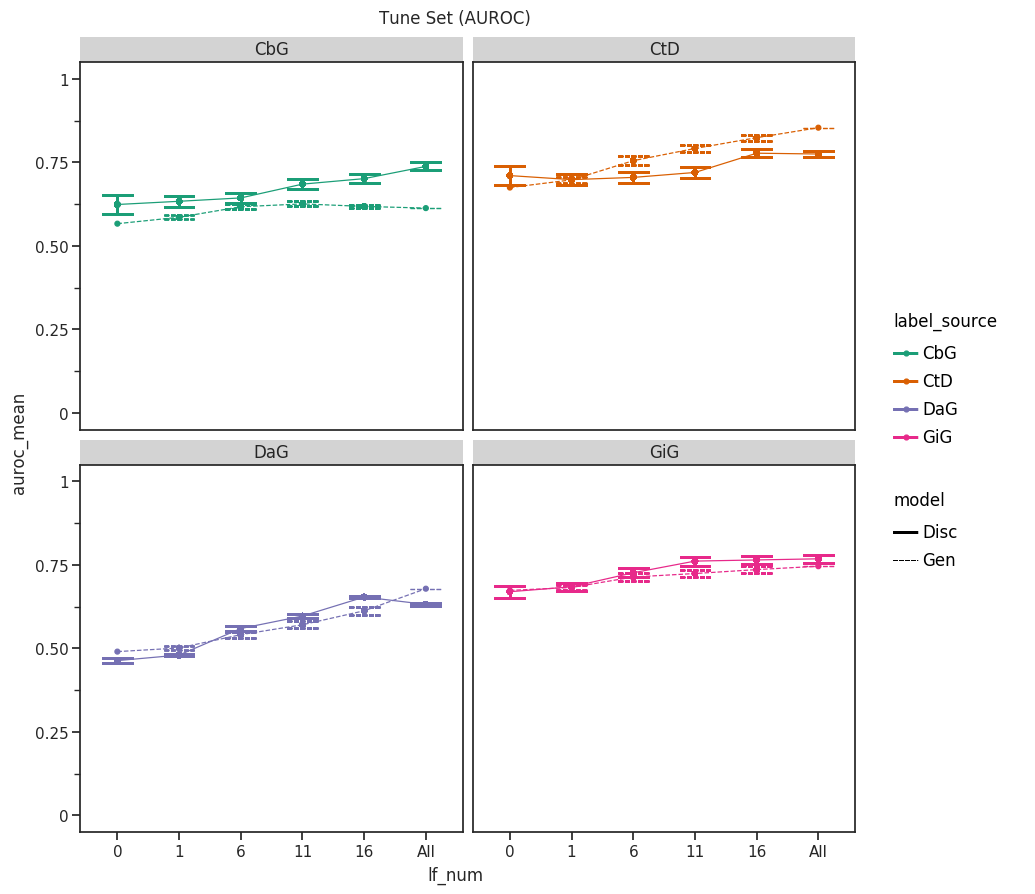

<ggplot: (-9223363293526185742)>


In [8]:
g = (
    p9.ggplot(performance_ci_df >> ply.query("dataset=='tune'"))
    + p9.aes(
        x="lf_num",
        y="auroc_mean",
        ymin="auroc_lower_ci",
        ymax="auroc_upper_ci",
        group="model",
        color="label_source",
        linetype="model",
    )
    + p9.geom_point()
    + p9.geom_line()
    + p9.geom_errorbar()
    + p9.scale_color_brewer(type="qual", palette=2)
    + p9.facet_wrap("~ prediction_label")
    + p9.scale_y_continuous(limits=[0, 1])
    + p9.theme_seaborn("white")
    + p9.labs(title="Tune Set (AUROC)")
    + p9.theme(figure_size=(10, 10))
)
print(g)

/home/danich1/anaconda3/envs/snorkeling_full_text/lib/python3.7/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_errorbar : Removed 4 rows containing missing values.


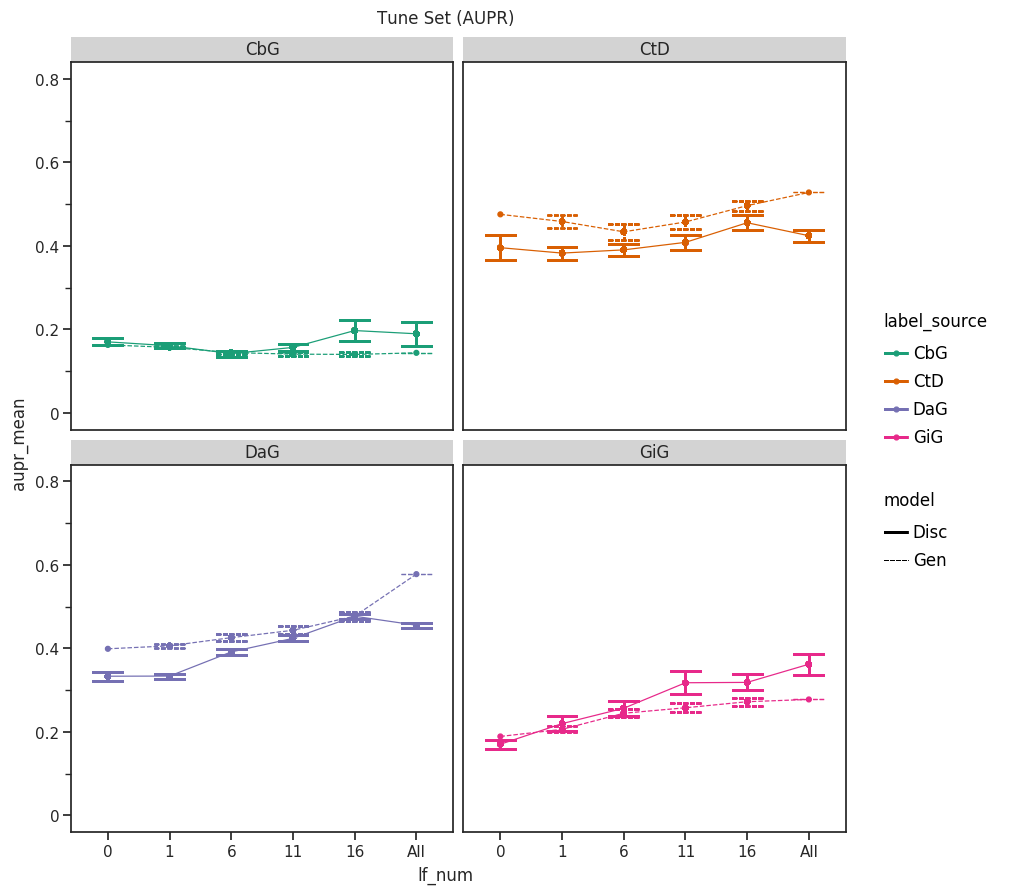

<ggplot: (8743325306951)>


In [9]:
g = (
    p9.ggplot(performance_ci_df >> ply.query("dataset=='tune'"))
    + p9.aes(
        x="lf_num",
        y="aupr_mean",
        ymin="aupr_lower_ci",
        ymax="aupr_upper_ci",
        group="model",
        color="label_source",
        linetype="model",
    )
    + p9.geom_point()
    + p9.geom_line()
    + p9.geom_errorbar()
    + p9.scale_color_brewer(type="qual", palette=2)
    + p9.facet_wrap("~ prediction_label")
    + p9.scale_y_continuous(limits=[0, 0.8])
    + p9.theme_seaborn("white")
    + p9.labs(title="Tune Set (AUPR)")
    + p9.theme(figure_size=(10, 10))
)
print(g)

## Test

/home/danich1/anaconda3/envs/snorkeling_full_text/lib/python3.7/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_errorbar : Removed 4 rows containing missing values.


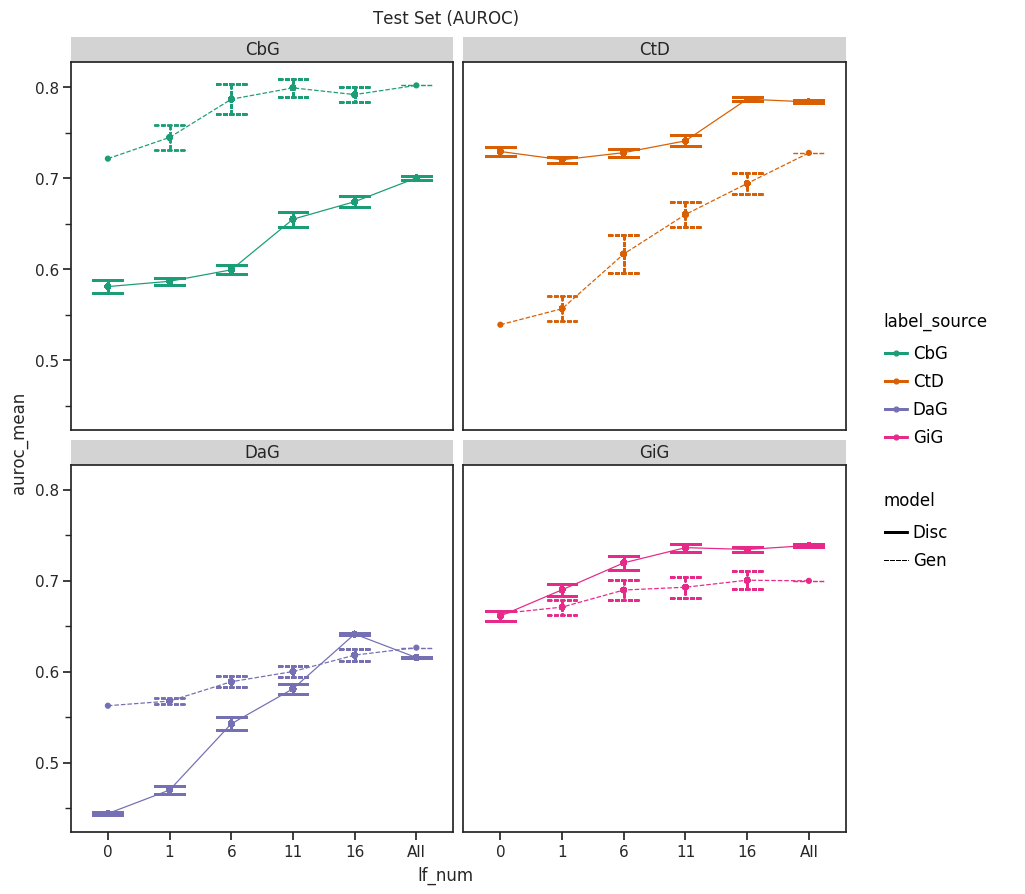

<ggplot: (-9223363293532196085)>


In [10]:
g = (
    p9.ggplot(performance_ci_df >> ply.query("dataset=='test'"))
    + p9.aes(
        x="lf_num",
        y="auroc_mean",
        ymin="auroc_lower_ci",
        ymax="auroc_upper_ci",
        group="model",
        color="label_source",
        linetype="model",
    )
    + p9.geom_point()
    + p9.geom_line()
    + p9.geom_errorbar()
    + p9.scale_color_brewer(type="qual", palette=2)
    + p9.facet_wrap("~ prediction_label")
    + p9.theme_seaborn("white")
    + p9.labs(title="Test Set (AUROC)")
    + p9.theme(figure_size=(10, 10))
)
print(g)

/home/danich1/anaconda3/envs/snorkeling_full_text/lib/python3.7/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_errorbar : Removed 4 rows containing missing values.


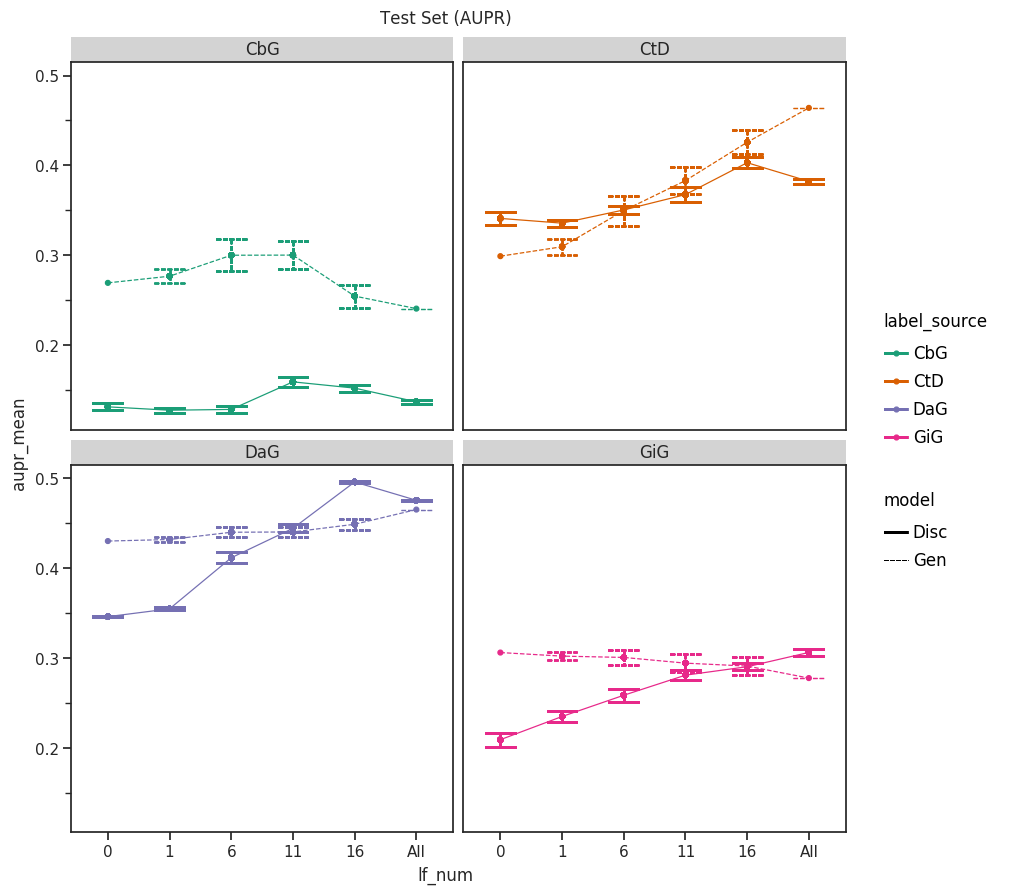

<ggplot: (8743321901737)>


In [11]:
g = (
    p9.ggplot(performance_ci_df >> ply.query("dataset=='test'"))
    + p9.aes(
        x="lf_num",
        y="aupr_mean",
        ymin="aupr_lower_ci",
        ymax="aupr_upper_ci",
        group="model",
        color="label_source",
        linetype="model",
    )
    + p9.geom_point()
    + p9.geom_line()
    + p9.geom_errorbar()
    + p9.scale_color_brewer(type="qual", palette=2)
    + p9.facet_wrap("~ prediction_label")
    + p9.theme_seaborn("white")
    + p9.labs(title="Test Set (AUPR)")
    + p9.theme(figure_size=(10, 10))
)
print(g)